In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-rna-3d-folding/sample_submission.csv
/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv
/kaggle/input/stanford-rna-3d-folding/test_sequences.csv
/kaggle/input/stanford-rna-3d-folding/train_labels.v2.csv
/kaggle/input/stanford-rna-3d-folding/validation_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_sequences.csv
/kaggle/input/stanford-rna-3d-folding/train_sequences.v2.csv
/kaggle/input/stanford-rna-3d-folding/MSA/R1108.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/8EVR_EC.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/1ZDI_S.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/5FJ1_H.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/2NBY_A.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/3DEG_J.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/2M21_A.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/8U3M_A.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/2OM7_F.MSA.fas

In [13]:
!pip install torch-geometric


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [14]:
MAX_SEQ_LEN = 1024

In [15]:
# Define paths to data files
TRAIN_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/train_sequences.csv"
TRAIN_LABELS_PATH = "/kaggle/input/stanford-rna-3d-folding/train_labels.csv"
# Load data
train_sequences = pd.read_csv(TRAIN_SEQUENCES_PATH)
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

print(f"Loaded {len(train_sequences)} RNA sequences and {len(train_labels)} nucleotide labels")

Loaded 844 RNA sequences and 137095 nucleotide labels


In [16]:
# Preprocess data
# 1. Encoding nucleotides
nucleotide_mapping = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
reverse_mapping = {0: 'A', 1: 'C', 2: 'G', 3: 'U'}

In [17]:
# 2. Create feature representation for each nucleotide
def one_hot_encode(nucleotide):
    encoding = [0, 0, 0, 0]
    if nucleotide in nucleotide_mapping:
        encoding[nucleotide_mapping[nucleotide]] = 1
    return encoding

In [18]:
# Function to create a graph from an RNA sequence
def sequence_to_graph(sequence, target_id, labels_df=None, max_connections=MAX_SEQ_LEN):
    """
    Create a graph representation of an RNA sequence.
    
    Args:
        sequence: The RNA sequence
        target_id: Identifier for the RNA
        labels_df: Optional dataframe with 3D coordinate labels
        max_connections: Maximum number of edges to create (to avoid CUDA OOM errors)
        
    Returns:
        PyTorch Geometric Data object
    """
    # One-hot encode each nucleotide
    x = [one_hot_encode(nt) for nt in sequence]
    x = torch.tensor(x, dtype=torch.float)
    
    # Create edges - connect adjacent nucleotides (backbone)
    # and potentially other connections based on domain knowledge
    edges = []
    
    # Always add backbone connections
    for i in range(len(sequence) - 1):
        # Connect to next nucleotide (backbone)
        edges.append([i, i + 1])
        edges.append([i + 1, i])  # Bidirectional
    
    # Add potential base-pairing connections, but limit total edges to avoid OOM
    edge_count = len(edges)
    max_additional_edges = max_connections - edge_count
    
    if max_additional_edges > 0:
        potential_base_pairs = []
        
        # Identify potential base pairs (A-U, G-C)
        for i in range(len(sequence)):
            for j in range(i + 3, len(sequence)):  # Minimum loop size of 3
                if (sequence[i] == 'A' and sequence[j] == 'U') or \
                   (sequence[i] == 'U' and sequence[j] == 'A') or \
                   (sequence[i] == 'G' and sequence[j] == 'C') or \
                   (sequence[i] == 'C' and sequence[j] == 'G'):
                    # Store the potential base pair
                    potential_base_pairs.append((i, j))
        
        # Randomly select base pairs if we have too many
        if len(potential_base_pairs) > max_additional_edges // 2:  # Divide by 2 for bidirectional edges
            # Shuffle and take only what we can handle
            random.shuffle(potential_base_pairs)
            potential_base_pairs = potential_base_pairs[:max_additional_edges // 2]
        
        # Add the selected base pairs
        for i, j in potential_base_pairs:
            edges.append([i, j])
            edges.append([j, i])  # Bidirectional
    
    # Convert edges to tensor
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    # Get coordinates if available
    y = None
    mask = None
    if labels_df is not None:
        target_labels = labels_df[labels_df['ID'].str.startswith(target_id + '_')]
        
        # Sort by residue ID to match sequence order
        target_labels = target_labels.sort_values(by='resid')
        
        # Check if we have the expected number of residues
        if len(target_labels) == len(sequence):
            # Extract coordinates for each residue
            coordinates = target_labels[['x_1', 'y_1', 'z_1']].values
            
            # Create a mask for NaN values (1 for valid, 0 for NaN)
            valid_mask = ~np.isnan(coordinates).any(axis=1)
            mask = torch.tensor(valid_mask, dtype=torch.float)
            
            # Replace NaN with zeros (we'll mask these during loss calculation)
            coordinates = np.nan_to_num(coordinates, nan=0.0)
            
            y = torch.tensor(coordinates, dtype=torch.float)
        else:
            print(f"Warning: Mismatch in sequence length and label count for {target_id}")
    
    # Create the data object with properly typed target_id (as string)
    data = Data(x=x, edge_index=edge_index, y=y, mask=mask)
    
    # Store target_id as a string attribute
    data.target_id = str(target_id)
    
    return data

In [19]:
def create_dataset(sequences_df, labels_df=None):
    dataset = []
    skipped_count = 0
    nan_count = 0
    
    for idx, row in tqdm(sequences_df.iterrows(), total=len(sequences_df)):
        target_id = row['target_id']
        sequence = row['sequence']
        
        # Clean sequence - replace any non-standard nucleotides with 'N'
        # and count how many non-standard nucleotides there are
        cleaned_sequence = ''
        non_standard_count = 0
        
        for nt in sequence:
            if nt in nucleotide_mapping:
                cleaned_sequence += nt
            else:
                cleaned_sequence += 'N'  # Placeholder for non-standard nucleotides
                non_standard_count += 1
        
        # If too many non-standard nucleotides (>10%), skip this sequence
        if non_standard_count / len(sequence) > 0.1:
            print(f"Skipping sequence {target_id} with {non_standard_count} non-standard nucleotides")
            skipped_count += 1
            continue
        
        # Create graph
        graph = sequence_to_graph(cleaned_sequence, target_id, labels_df)
        
        # Check if we have labels with many NaN values
        if labels_df is not None and hasattr(graph, 'mask') and graph.mask is not None:
            nan_percentage = 1.0 - torch.mean(graph.mask).item()
            if nan_percentage > 0.5:  # If more than 50% coordinates are NaN
                print(f"Warning: Sequence {target_id} has {nan_percentage:.1%} NaN coordinates")
                nan_count += 1
        
        # Add to dataset if no labels needed or valid labels exist
        if labels_df is None or graph.y is not None:
            dataset.append(graph)
    
    print(f"Dataset creation: {skipped_count} sequences skipped due to non-standard nucleotides")
    print(f"Dataset creation: {nan_count} sequences have >50% NaN coordinates")
    
    return dataset

In [20]:
data={
      "sequence":train_sequences['sequence'].to_list(),
      "temporal_cutoff": train_sequences['temporal_cutoff'].to_list(),
      "description": train_sequences['description'].to_list(),
      "all_sequences": train_sequences['all_sequences'].to_list(),
}
config = {
    "cutoff_date": "2020-01-01",
    "test_cutoff_date": "2022-05-01",
}

In [21]:
# Split data into train and test
all_index = np.arange(len(data['sequence']))
cutoff_date = pd.Timestamp(config['cutoff_date'])
test_cutoff_date = pd.Timestamp(config['test_cutoff_date'])
train_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) <= cutoff_date]
test_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) > cutoff_date and pd.Timestamp(d) <= test_cutoff_date]

In [22]:
# Create training dataset
train_dataset = create_dataset(train_sequences, train_labels)
print(f"Created {len(train_dataset)} graph data objects for training")

 13%|█▎        | 112/844 [00:03<00:23, 30.56it/s]

 16%|█▌        | 132/844 [00:04<00:23, 30.59it/s]

 17%|█▋        | 140/844 [00:04<00:22, 30.68it/s]

 18%|█▊        | 148/844 [00:04<00:22, 30.83it/s]

 20%|█▉        | 168/844 [00:05<00:21, 31.31it/s]

 21%|██▏       | 180/844 [00:05<00:21, 30.33it/s]

 22%|██▏       | 184/844 [00:05<00:21, 30.54it/s]

 25%|██▍       | 210/844 [00:06<00:21, 29.13it/s]

 26%|██▌       | 217/844 [00:07<00:23, 26.91it/s]

 28%|██▊       | 235/844 [00:07<00:22, 27.01it/s]

 29%|██▉       | 245/844 [00:08<00:21, 27.91it/s]

 34%|███▍      | 285/844 [00:09<00:18, 30.27it/s]

 36%|███▌      | 305/844 [00:10<00:17, 30.80it/s]

 37%|███▋      | 313/844 [00:10<00:17, 30.71it/s]

 41%|████      | 346/844 [00:11<00:17, 29.07it/s]

 51%|█████     | 427/844 [00:14<00:13, 31.22it/s]

 52%|█████▏    | 443/844 [00:14<00:12, 31.12it/s]

 53%|█████▎    | 451/844 [00:14<00:13, 30.20it/s]

 55%|█████▍    | 462/844 [00:15<00:12, 29.40it/s]

 56%|█████▌    | 470/844 [00:15<00:12, 31.04it/s]

 60%|██████    | 510/844 [00:16<00:10, 31.42it/s]

 69%|██████▉   | 582/844 [00:19<00:08, 29.52it/s]

 71%|███████   | 596/844 [00:19<00:08, 29.91it/s]

 73%|███████▎  | 616/844 [00:20<00:07, 29.64it/s]

 76%|███████▋  | 644/844 [00:21<00:06, 29.10it/s]

 80%|███████▉  | 675/844 [00:22<00:05, 30.50it/s]

 82%|████████▏ | 692/844 [00:23<00:05, 25.94it/s]

 93%|█████████▎| 788/844 [00:26<00:02, 27.35it/s]

 95%|█████████▌| 806/844 [00:27<00:01, 26.53it/s]

 96%|█████████▋| 813/844 [00:27<00:01, 27.72it/s]

100%|██████████| 844/844 [00:28<00:00, 29.53it/s]

Dataset creation: 0 sequences skipped due to non-standard nucleotides
Dataset creation: 69 sequences have >50% NaN coordinates
Created 844 graph data objects for training


In [23]:
train_graphs = train_dataset[:len(train_index)]
val_graphs = train_dataset[:len(train_index)]

## Visualize

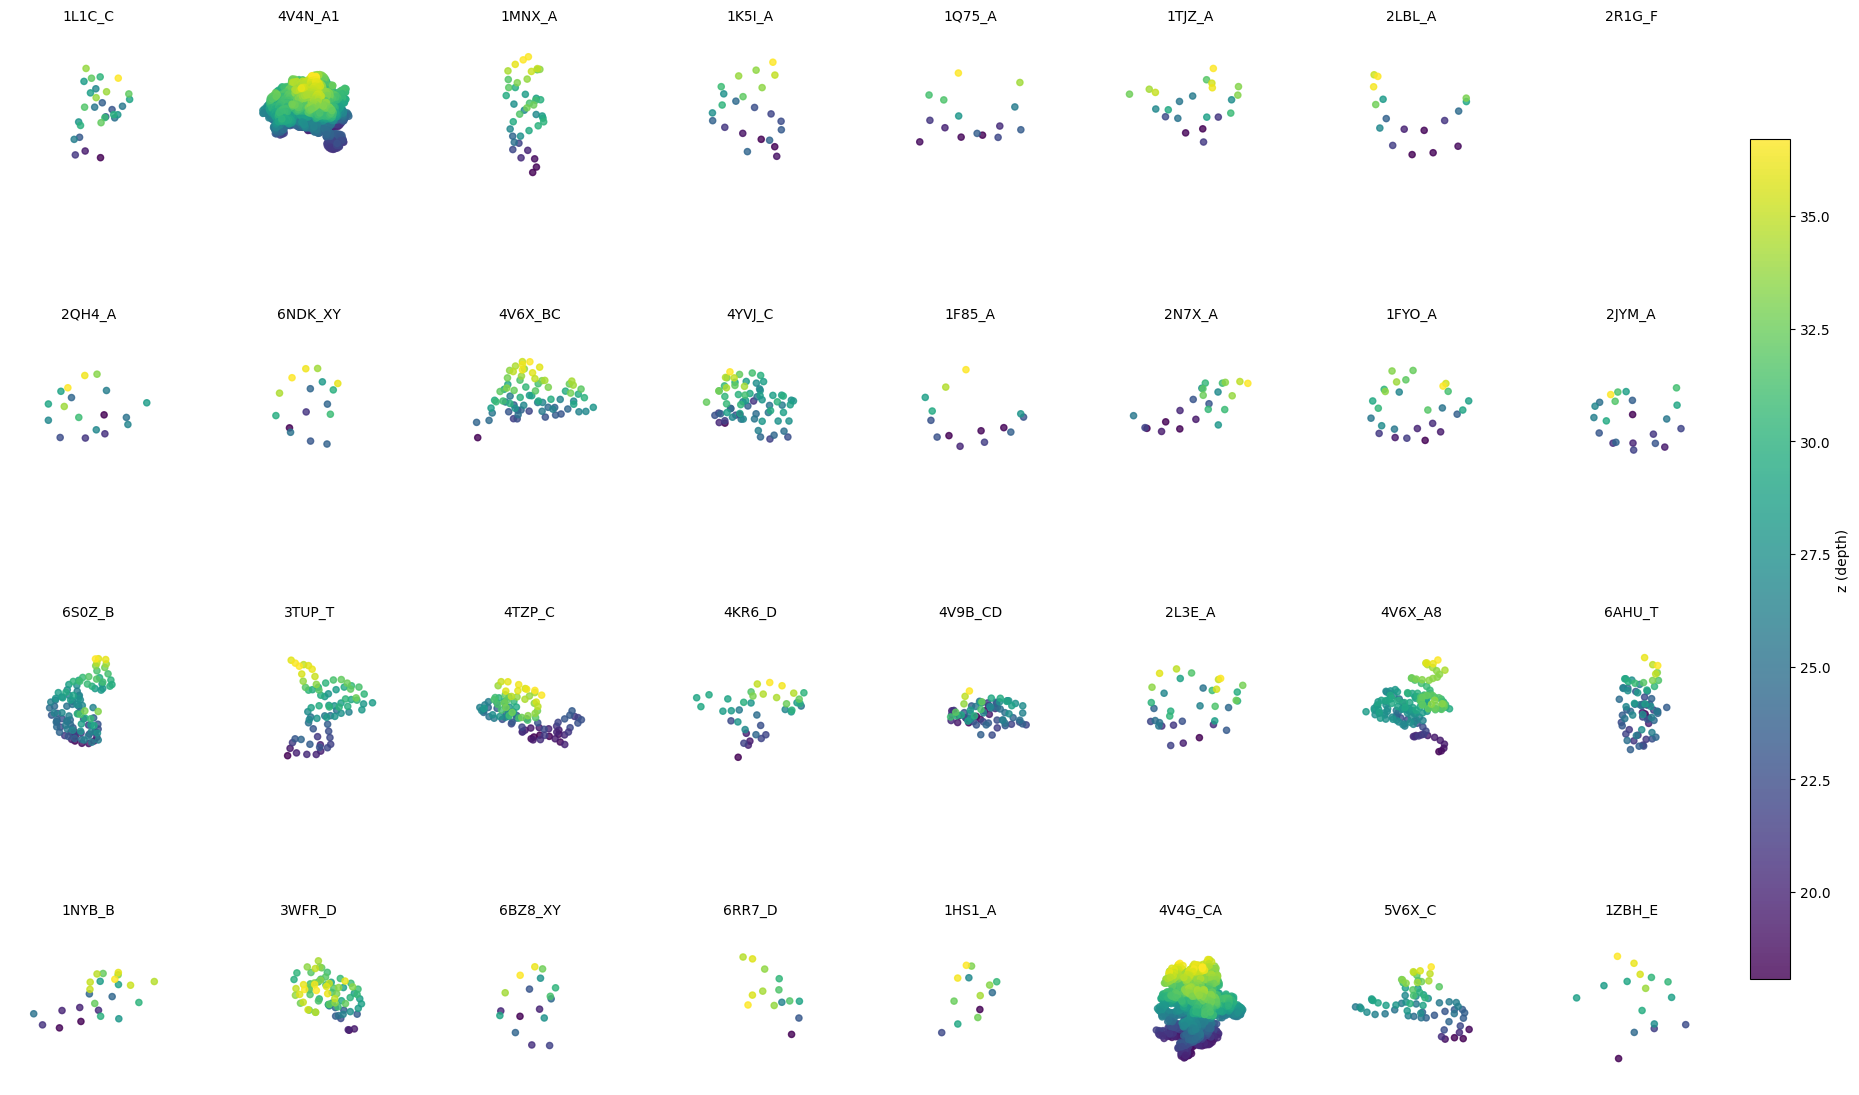

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique target_ids from the dataset
all_target_ids = [data.target_id for data in train_graphs]
unique_target_ids = list(set(all_target_ids))

# Randomly sample 32 unique target_ids
selected_target_ids = np.random.choice(unique_target_ids, size=32, replace=False)

# Create 4x8 grid of subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

for i, target_id in enumerate(selected_target_ids):
    axes[i].axis('off')

    # Find the corresponding graph in the dataset
    graph = next((g for g in train_dataset if g.target_id == target_id), None)
    
    if graph is None or graph.y is None:
        continue

    coords = graph.y.numpy()
    valid_mask = graph.mask.numpy().astype(bool) if graph.mask is not None else np.ones(len(coords), dtype=bool)

    x = coords[valid_mask, 0]
    y = coords[valid_mask, 1]
    z = coords[valid_mask, 2]

    sc = axes[i].scatter(x, y, z, c=z, cmap='viridis', alpha=0.8)
    axes[i].view_init(elev=30, azim=45)
    axes[i].set_title(f'{target_id}', fontsize=10, pad=10)

# Add shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax, label='z (depth)', orientation='vertical')

# Adjust layout
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.6)

# Show plot
plt.show()


In [25]:
!pip install egnn-pytorch
from egnn_pytorch import EGNN  # or your own EGNN implementation


In [38]:
!pip install torch torch_geometric torch_scatter tqdm -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
import torch_scatter
from tqdm import tqdm



class EGNNLayer(MessagePassing):
    def __init__(self, hidden_dim):
        super().__init__(aggr='add')
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim + 1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )
        self.coord_mlp = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, x, edge_index, coords):
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, coords=coords)

    def message(self, x_i, x_j, coords_i, coords_j):
        rel_coords = coords_i - coords_j
        dist = torch.sum(rel_coords ** 2, dim=-1, keepdim=True)
        edge_input = torch.cat([x_i, x_j, dist], dim=-1)
        m_ij = self.edge_mlp(edge_input)
        coord_update = self.coord_mlp(m_ij) * rel_coords
        return m_ij, coord_update

    def aggregate(self, inputs, index):
        msgs, coord_updates = inputs
        return (
            torch_scatter.scatter(msgs, index, dim=0),
            torch_scatter.scatter(coord_updates, index, dim=0)
        )

    def update(self, aggr_out, x, coords):
        x_update, coord_update = aggr_out
        x = x + self.node_mlp(x_update)
        coords = coords + coord_update
        return x, coords

class EGNNRNAStructurePredictor(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=128, num_layers=4, max_seq_len=512):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.egnn_layers = nn.ModuleList([EGNNLayer(hidden_dim) for _ in range(num_layers)])
        self.coord_predictor = nn.Linear(hidden_dim, 3)
        self.position_encoder = nn.Embedding(max_seq_len, hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.embedding(x)
        pos_indices = torch.arange(h.size(0), device=h.device).clamp(max=self.position_encoder.num_embeddings - 1)
        h = h + self.position_encoder(pos_indices)
        coords = torch.zeros(x.size(0), 3, device=x.device)
        for layer in self.egnn_layers:
            h, coords = layer(h, edge_index, coords)
        return coords

# Dummy RNA graph generator
def generate_dummy_dataset(n_graphs=50):
    dataset = []
    for i in range(n_graphs):
        num_nodes = torch.randint(10, 20, (1,)).item()
        x = F.one_hot(torch.randint(0, 4, (num_nodes,)), num_classes=4).float()
        edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
        y = torch.rand((num_nodes, 3))
        mask = torch.ones(num_nodes)
        data = Data(x=x, edge_index=edge_index, y=y, mask=mask, target_id=f"RNA_{i}")
        dataset.append(data)
    return dataset

# Initialize model and data
dummy_dataset = generate_dummy_dataset()
loader = DataLoader(dummy_dataset, batch_size=4, shuffle=True)
model = EGNNRNAStructurePredictor(input_dim=4, hidden_dim=64, num_layers=3).to("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 2000
best_val_loss = float("inf")
early_stopping_patience = 150
early_stopping_counter = 0

train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(1, num_epochs + 1):
    # --- Train ---
    train_loss = train(model, train_loader, optimizer, device)
    train_losses.append(train_loss)

    # --- Validate ---
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)

    # --- Adjust Learning Rate ---
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # --- Check for Improvement ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_rna_structure_model.pt")
    else:
        early_stopping_counter += 1

    # --- Display formatted output ---
    print(f"Epoch {epoch:4d}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"LR: {current_lr:.6f}")

    # --- Early Stopping ---
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

print("Training completed.")


Starting training with early stopping...


Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 89.09it/s, loss=0.325]


Epoch 1 average loss: 0.3364
✅ Best model saved.


Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 88.25it/s, loss=0.283]


Epoch 2 average loss: 0.3344
✅ Best model saved.


Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 92.19it/s, loss=0.315]


Epoch 3 average loss: 0.3357
⚠️  No improvement. Patience: 1/5


Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 93.39it/s, loss=0.322]


Epoch 4 average loss: 0.3365
⚠️  No improvement. Patience: 2/5


Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 94.23it/s, loss=0.307]


Epoch 5 average loss: 0.3360
⚠️  No improvement. Patience: 3/5


Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 94.13it/s, loss=0.376]


Epoch 6 average loss: 0.3379
⚠️  No improvement. Patience: 4/5


Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 91.54it/s, loss=0.367]

Epoch 7 average loss: 0.3374
⚠️  No improvement. Patience: 5/5
⏹️  Early stopping at epoch 7. Best loss: 0.3344
Training completed.


In [31]:
# Define loss function for 3D coordinate prediction
def rmsd_loss(pred, target, mask=None):
    """
    Root Mean Square Deviation (RMSD) loss function with optional masking for NaN values.
    Lower RMSD indicates better structural similarity.
    
    Args:
        pred: Predicted coordinates, shape (n_nucleotides, 3)
        target: Target coordinates, shape (n_nucleotides, 3)
        mask: Optional mask for valid values, shape (n_nucleotides,)
    """
    squared_diff = torch.sum((pred - target) ** 2, dim=1)
    
    if mask is not None:
        # Apply mask to consider only valid coordinates
        # Ensure we don't divide by zero by adding a small epsilon to the sum
        masked_squared_diff = squared_diff * mask
        mean_squared_diff = torch.sum(masked_squared_diff) / (torch.sum(mask) + 1e-10)
    else:
        mean_squared_diff = torch.mean(squared_diff)
    
    rmsd = torch.sqrt(mean_squared_diff)
    return rmsd

In [32]:
def calculate_distance_matrix(X,Y,epsilon=1e-4):
    return (torch.square(X[:,None]-Y[None,:])+epsilon).sum(-1).sqrt()


def dRMSD(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=None):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)



    mask=~torch.isnan(gt_dm)
    mask[torch.eye(mask.shape[0]).bool()]=False

    if d_clamp is not None:
        rmsd=(torch.square(pred_dm[mask]-gt_dm[mask])+epsilon).clip(0,d_clamp**2)
    else:
        rmsd=torch.square(pred_dm[mask]-gt_dm[mask])+epsilon

    return rmsd.sqrt().mean()/Z

def local_dRMSD(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=30):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)



    mask=(~torch.isnan(gt_dm))*(gt_dm<d_clamp)
    mask[torch.eye(mask.shape[0]).bool()]=False



    rmsd=torch.square(pred_dm[mask]-gt_dm[mask])+epsilon
    # rmsd=(torch.square(pred_dm[mask]-gt_dm[mask])+epsilon).sqrt()/Z
    #rmsd=torch.abs(pred_dm[mask]-gt_dm[mask])/Z
    return rmsd.sqrt().mean()/Z

def dRMAE(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=None):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)



    mask=~torch.isnan(gt_dm)
    mask[torch.eye(mask.shape[0]).bool()]=False

    rmsd=torch.abs(pred_dm[mask]-gt_dm[mask])

    return rmsd.mean()/Z

import torch

def align_svd_mae(input, target, Z=10):
    """
    Aligns the input (Nx3) to target (Nx3) using SVD-based Procrustes alignment
    and computes RMSD loss.
    
    Args:
        input (torch.Tensor): Nx3 tensor representing the input points.
        target (torch.Tensor): Nx3 tensor representing the target points.
    
    Returns:
        aligned_input (torch.Tensor): Nx3 aligned input.
        rmsd_loss (torch.Tensor): RMSD loss.
    """
    assert input.shape == target.shape, "Input and target must have the same shape"

    #mask 
    mask=~torch.isnan(target.sum(-1))

    input=input[mask]
    target=target[mask]
    
    # Compute centroids
    centroid_input = input.mean(dim=0, keepdim=True)
    centroid_target = target.mean(dim=0, keepdim=True)

    # Center the points
    input_centered = input - centroid_input.detach()
    target_centered = target - centroid_target

    # Compute covariance matrix
    cov_matrix = input_centered.T @ target_centered

    # SVD to find optimal rotation
    U, S, Vt = torch.svd(cov_matrix)

    # Compute rotation matrix
    R = Vt @ U.T

    # Ensure a proper rotation (det(R) = 1, no reflection)
    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt @ U.T

    # Rotate input
    aligned_input = (input_centered @ R.T.detach()) + centroid_target.detach()

    # # Compute RMSD loss
    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())

    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())
    
    # return aligned_input, rmsd_loss
    return torch.abs(aligned_input-target).mean()/Z

In [33]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    loss_values = []
    # Create tqdm progress bar with loss display
    pbar = tqdm(train_loader, desc='Training')
    
    for data in pbar:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        pred = model(data)
        
        # Calculate loss if labels exist
        if data.y is not None:
            # Use mask if available
            if hasattr(data, 'mask') and data.mask is not None:
                loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                # loss = rmsd_loss(pred, data.y, data.mask)
            else:
                loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                # loss = rmsd_loss(pred, data.y)
                
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loss_values.append(loss.item())
            
            # Update progress bar with current loss
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'smooth loss': np.mean(loss_values[-100:])})
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    
    # Create tqdm progress bar with loss display
    pbar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for data in pbar:
            data = data.to(device)
            pred = model(data)
            
            if data.y is not None:
                # Use mask if available
                if hasattr(data, 'mask') and data.mask is not None:
                    loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                    # loss = rmsd_loss(pred, data.y, data.mask)
                else:
                    loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                    # loss = rmsd_loss(pred, data.y)
                total_loss += loss.item()
                
                # Update progress bar with current loss
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss

In [34]:
# Function to make predictions on test data
def predict(model, test_loader, device):
    model.eval()
    predictions = {}
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            pred = model(data)
            
            # Store predictions
            target_id = data.target_id
            
            # If we have ground truth and mask, report metrics
            if hasattr(data, 'y') and data.y is not None:
                if hasattr(data, 'mask') and data.mask is not None:
                    loss = rmsd_loss(pred, data.y, data.mask).item()
                else:
                    loss = rmsd_loss(pred, data.y).item()
                print(f"Prediction for {target_id}, RMSD: {loss:.4f}")
            
            predictions[target_id] = pred.cpu().numpy()
    
    return predictions

In [35]:
# Setup for training
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
device = torch.device(device)
print(f"Using device: {device}")

Using device: cuda


In [36]:
# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_graphs, batch_size=8, shuffle=False, num_workers=4)

In [71]:
# Initialize model
input_dim = 4  # One-hot encoding dimension for nucleotides
model = RNAStructurePredictor(input_dim=4, hidden_dim=128, output_dim=3, num_layers=6, max_seq_len=MAX_SEQ_LEN).to(device)
print(f"Model initialized with max sequence length of 10000")

Model initialized with max sequence length of 10000


In [72]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=12)

In [43]:
!pip install torch torch_geometric torch_scatter tqdm -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
import torch_scatter
from tqdm import tqdm



class EGNNLayer(MessagePassing):
    def __init__(self, hidden_dim):
        super().__init__(aggr='add')
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim + 1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )
        self.coord_mlp = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, x, edge_index, coords):
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, coords=coords)

    def message(self, x_i, x_j, coords_i, coords_j):
        rel_coords = coords_i - coords_j
        dist = torch.sum(rel_coords ** 2, dim=-1, keepdim=True)
        edge_input = torch.cat([x_i, x_j, dist], dim=-1)
        m_ij = self.edge_mlp(edge_input)
        coord_update = self.coord_mlp(m_ij) * rel_coords
        return m_ij, coord_update

    def aggregate(self, inputs, index):
        msgs, coord_updates = inputs
        return (
            torch_scatter.scatter(msgs, index, dim=0),
            torch_scatter.scatter(coord_updates, index, dim=0)
        )

    def update(self, aggr_out, x, coords):
        x_update, coord_update = aggr_out
        x = x + self.node_mlp(x_update)
        coords = coords + coord_update
        return x, coords

class EGNNRNAStructurePredictor(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=4, max_seq_len=MAX_SEQ_LEN):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.egnn_layers = nn.ModuleList([EGNNLayer(hidden_dim) for _ in range(num_layers)])
        self.coord_predictor = nn.Linear(hidden_dim, 3)
        self.position_encoder = nn.Embedding(max_seq_len, hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.embedding(x)
        pos_indices = torch.arange(h.size(0), device=h.device).clamp(max=self.position_encoder.num_embeddings - 1)
        h = h + self.position_encoder(pos_indices)
        coords = torch.zeros(x.size(0), 3, device=x.device)
        for layer in self.egnn_layers:
            h, coords = layer(h, edge_index, coords)
        return coords

# Initialize model and data
model = EGNNRNAStructurePredictor(input_dim=4, hidden_dim=64, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=12)

num_epochs = 100
best_val_loss = float("inf")
early_stopping_patience = 50
early_stopping_counter = 0

train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(1, num_epochs + 1):
    # --- Train ---
    train_loss = train(model, train_loader, optimizer, device)
    train_losses.append(train_loss)

    # --- Validate ---
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)

    # --- Adjust Learning Rate ---
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # --- Check for Improvement ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_rna_structure_model.pt")
    else:
        early_stopping_counter += 1

    # --- Display formatted output ---
    print(f"Epoch {epoch:4d}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"LR: {current_lr:.6f}")

    # --- Early Stopping ---
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

print("Training completed.")


Starting training...


Validation: 100%|██████████| 76/76 [00:03<00:00, 22.51it/s, loss=21.8392]


Epoch    1/2000, Train Loss: 19.1859, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 23.27it/s, loss=21.8392]


Epoch    2/2000, Train Loss: 18.5543, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 22.08it/s, loss=21.8392]


Epoch    3/2000, Train Loss: 18.2573, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 23.39it/s, loss=21.8392]


Epoch    4/2000, Train Loss: 17.6820, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 23.59it/s, loss=21.8392]


Epoch    5/2000, Train Loss: 17.2471, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 23.37it/s, loss=21.8392]


Epoch    6/2000, Train Loss: 18.5215, Val Loss: 13.3715, LR: 0.001000


Training:  54%|█████▍    | 41/76 [00:02<00:02, 14.00it/s, loss=23.4800, smooth loss=19.5]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.03 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.39 GiB is free. Process 7504 has 13.35 GiB memory in use. Of the allocated memory 10.15 GiB is allocated by PyTorch, and 3.04 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)